#### (IMPORT STATEMENTS)

In [1]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
from jupyterthemes import jtplot

# jt -t onedork -tf latosans -tfs 15 -lineh 170 -ofs 14
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
set_nb_theme('onedork')
jtplot.style(theme='onedork')
jtplot.style(ticks=True, grid=False)
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

---
# LOCALIZATION 
---

- Give the robot the ability to locate itself in the world 

GIVEN: 
  - A true (and non-changing) map of the world
  - Sensor measurement at a particular time
  - Motion control at a particular time

FIND: 
  - In the world map at a particular time, where am I?

---
# HISTOGRAM FILTERS
### (A.K.A MONTE-CARLO LOCALIZATION)
---

- Repetition of sensing and moving
- Updates belief about robot's location over possible locations 
- Mathematically, updates probability distribution over sample space

![](./img/hf-summary.png)

---
---
## INTUITION
---
---

GIVEN: 
- A one-dimensional known map 
- You are a clueless robot! (Atleast for now!) 

TASK:
- Try to locate yourself within the known map!  

![](./img/hf-intuition.png)

If your histogram filter is working properly:
  1. There should be ONE SHARP PEAK 
  2. That SHARP PEAK should be correct

In other words, we should be very certain about where we are!

1. Start with an initial belief: MAXIMUM CONFUSION!
2. THEN: 
  - SENSE -> Update belief (we become more certain)
  - MOVE -> Update belief (we become less certain)
  - REPEAT!

----
----
## SENSE STEP
----
----

- Calculate the probability of where we are, given a sensor measurement
- Given a simplified cyclical world of green and red cells
- If our sensor measurement is the same as the color of the cell, multiply by a large factor
- Otherwise, multiply by a small factor
- Normalize so that the sum of all cells equals one. 

![SENSING](./img/sensing.png)

----
----
## MOVE STEP
----
----

### THE CASE OF EXACT MOTION

- Given that you have the respective probability for each grid cell, where the sum of all probably is equal to one, IE `P1 + P2 + P3 + P4 + P5 = 1`

```
....................................
|  P1  |  P2  |  P3  |  P4  |  P5  |
....................................
```

- If you have exact motion, and you move exactly one grid cell to the right, the probablities will just shift accordingly.

```
....................................
|  P5  |  P1  |  P2  |  P3  |  P4  |
....................................
```
- Similarly, if you move exactly two grid cells to the left, the probablities will just shift accordingly.

```
....................................
|  P3  |  P4  |  P5  |  P1  |  P2  |
....................................
```

### THE CASE OF INEXACT MOTION

![](./img/1-move.png) 
![](./img/2-move.png)
![](./img/3-move.png)
![](./img/4-move.png)


#### (HELPER FUNCTIONS)

In [2]:
# prints probability for each cell in a nice format
def formatted_print(s, l):
  s = str(s)
  print('{:15}: '.format(s), end = "")
    
  for i in range(len(l)):
    print("{:.3f} |".format(l[i]), " ", end = "")

  print()

In [3]:
# shows bar chart of probabilities 
def plot_probability(probability, world):
  indices = np.arange(5)
  plt.figure(figsize=(20,10))
  plt.bar(indices, probability, align='center', color ='#947CB0')
  plt.xticks(indices, world, fontsize = 30)
  plt.ylabel('PROBABILITY', fontsize = 30)
  plt.ylim((0, 1.0))
  plt.show()

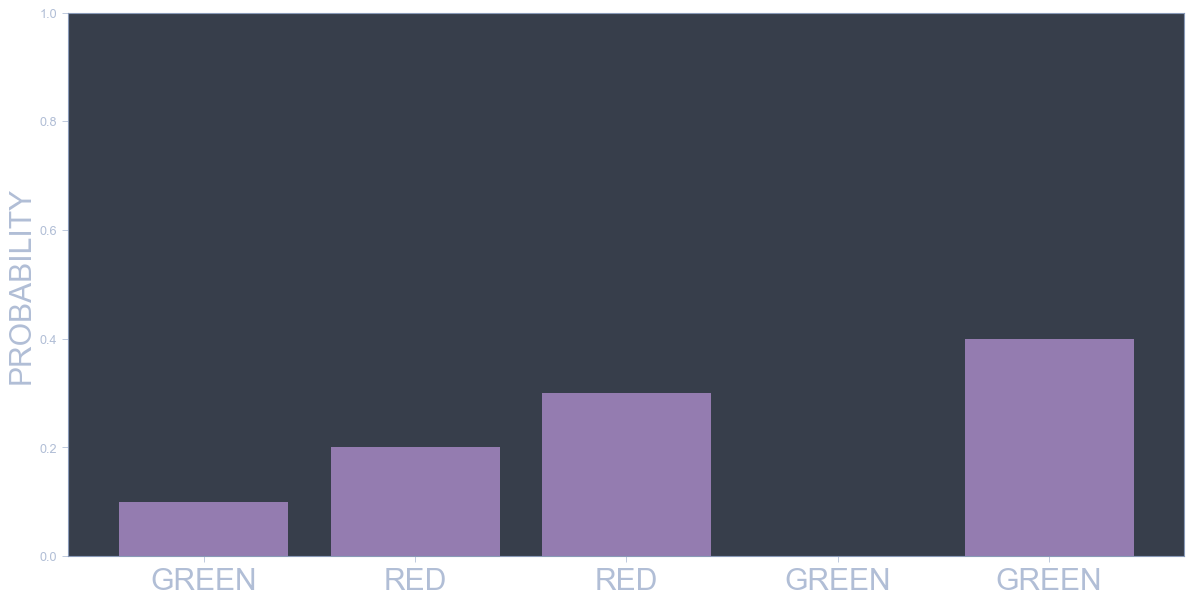

Test1          : 0.100 |  0.200 |  0.300 |  0.000 |  0.400 |  


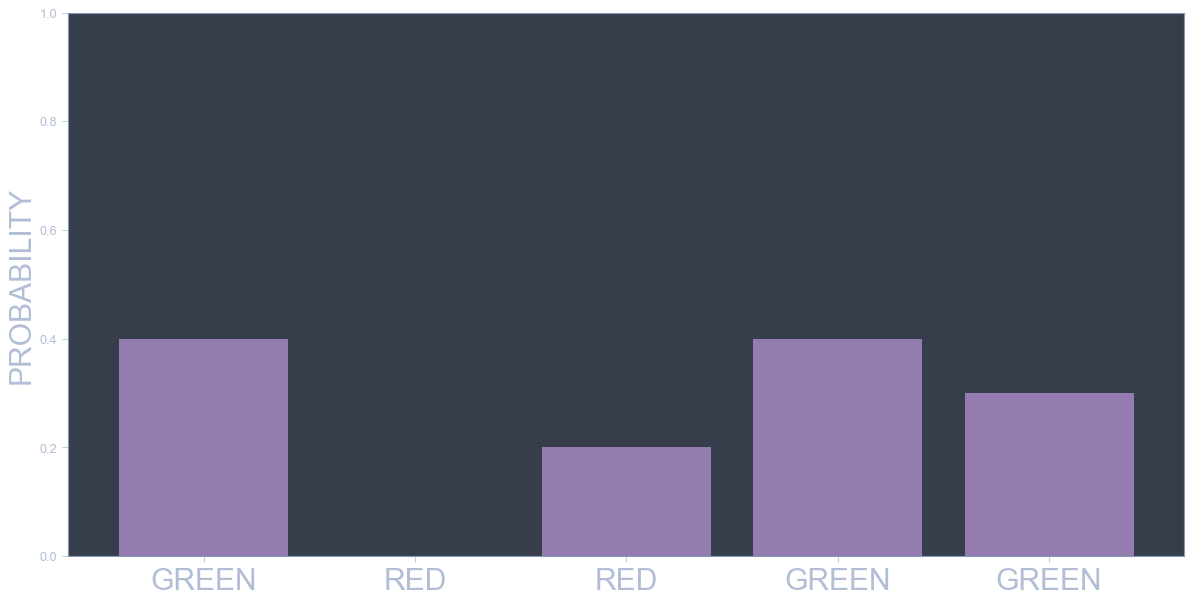

Test2          : 0.400 |  0.000 |  0.200 |  0.400 |  0.300 |  


In [4]:
# Test function if they're working
def visualize(probability, world, label):
  plot_probability(probability, world)
  formatted_print(label, probability)
    
    
probability1 = np.array([0.1, 0.2, 0.3, 0.0, 0.4])
probability2 = np.array([0.4, 0.0, 0.2, 0.4, 0.3])
world = ('GREEN', 'RED', 'RED', 'GREEN', 'GREEN')

visualize(probability1, world, "Test1")
visualize(probability2, world, "Test2")



# 1D HISTOGRAM FILTER CLASS


In [5]:
class HistogramFilter1D:
  def __init__(self, world_map, hit_weight = 0.6, miss_weight = 0.2, 
                undershoot_prob = 0.1, overshoot_prob = 0.1, exact_prob = 0.8):
    
    self.hit_weight = hit_weight
    self.miss_weight = miss_weight
    
    self.world_map = world_map
    self.world_size = len(world_map)
    
    # Current is list of probability for each cell
    # Current distribution
    self.current = self.confuse() 
    
    self.undershoot_prob = undershoot_prob
    self.overshoot_prob = overshoot_prob
    self.exact_prob = exact_prob

  def set_current(self, prob):
    self.current = prob

  def get_current(self):
    return self.current 

  def confuse(self):
    self.current = [1 / self.world_size] * self.world_size
    return self.current
  
  def sense(self, value):
    
    def normalize(x):
      s = sum(x)
      for i in range(len(x)):
        x[i] = x[i] / s
      return x
    
    for i in range(self.world_size):
      if value == self.world_map[i]:
        self.current[i] = self.hit_weight * self.current[i]
      else:
        self.current[i] = self.miss_weight * self.current[i]
    
    self.current = normalize(self.current)
    return self.current

  def move(self, steps): # cyclical world
    
    temp = [0] * self.world_size
    
    for position in range(self.world_size):
      val = self.current[position]  
      loc_exact = (position + steps) % self.world_size
      loc_over = (position + steps + 1) % self.world_size
      loc_under =  (position + steps - 1) % self.world_size
    
      temp[loc_exact] += val * self.exact_prob
      temp[loc_over] += val * self.overshoot_prob
      temp[loc_under] += val * self.undershoot_prob
    
    self.current = temp 
    return temp

#### (INITIALIZE OUR 1D FILTER)

In [6]:
world = ['green', 'red', 'red', 'green', 'green']
robot = HistogramFilter1D(world_map = world, 
          hit_weight = 0.6, miss_weight = 0.2,
          exact_prob = 0.8, undershoot_prob = 0.1, overshoot_prob = 0.1)

# (EXAMPLE 1)
- Given we don't know anything. 
- First we sensed red, then without moving, we sensed green 

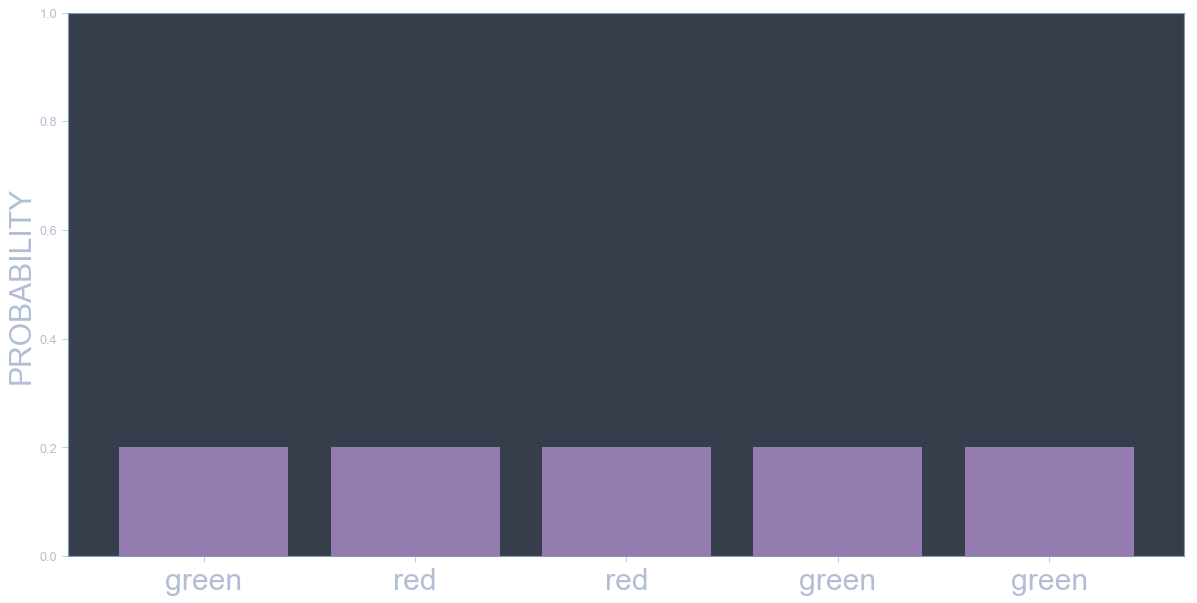

initial        : 0.200 |  0.200 |  0.200 |  0.200 |  0.200 |  


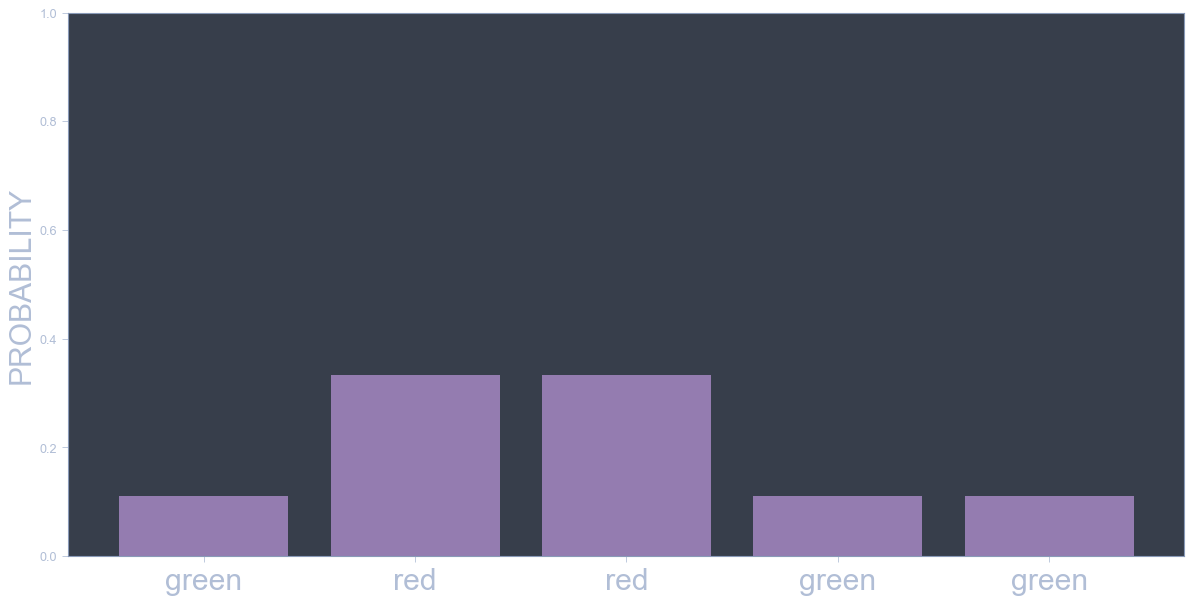

sensed red:    : 0.111 |  0.333 |  0.333 |  0.111 |  0.111 |  


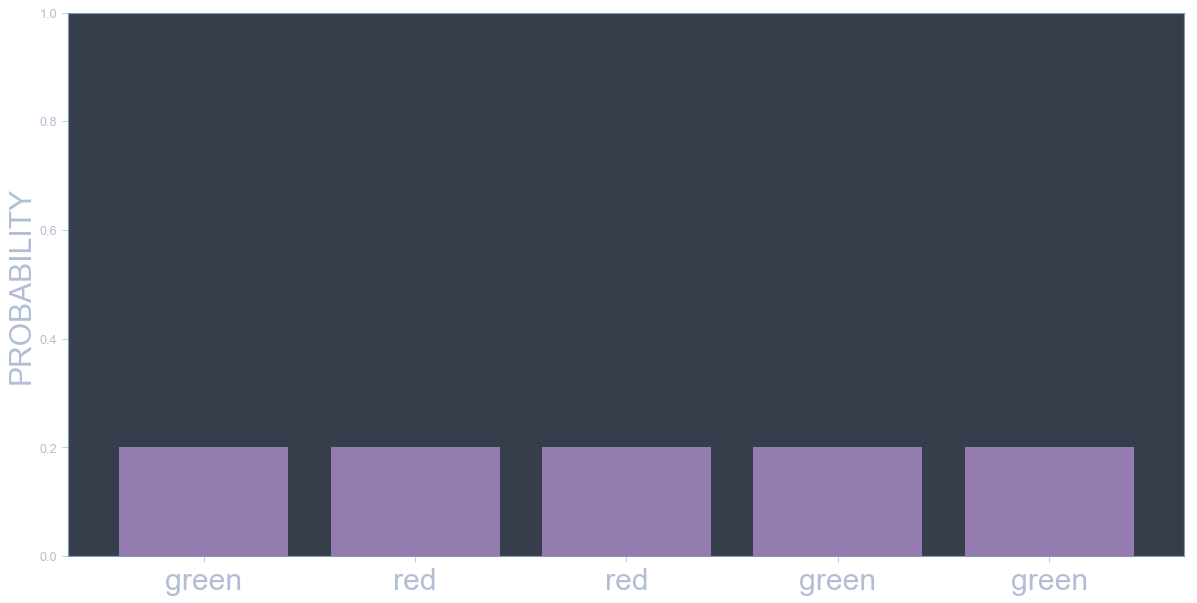

sensed green:  : 0.200 |  0.200 |  0.200 |  0.200 |  0.200 |  


In [7]:
robot.confuse()
visualize(robot.current, world, "initial")
visualize(robot.sense('red'), world, "sensed red:")
visualize(robot.sense('green'), world, "sensed green:")

# (EXAMPLE 2)
- Given we are 100% sure that we are on the second cell
- Then we moved one step
- Then after we moved 1000 steps

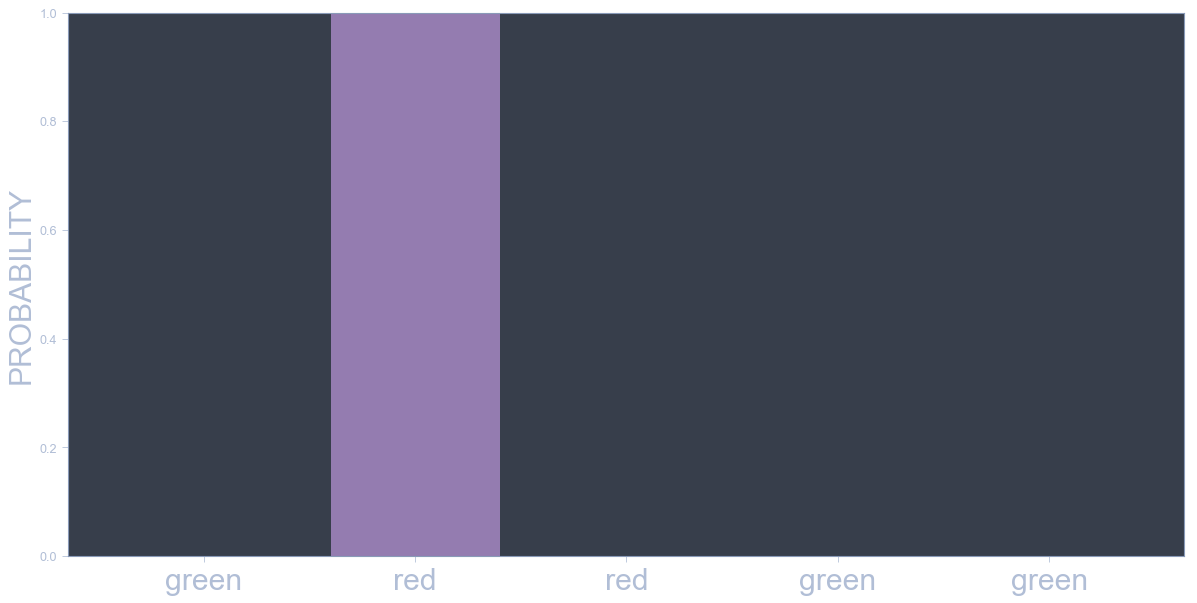

initial        : 0.000 |  1.000 |  0.000 |  0.000 |  0.000 |  


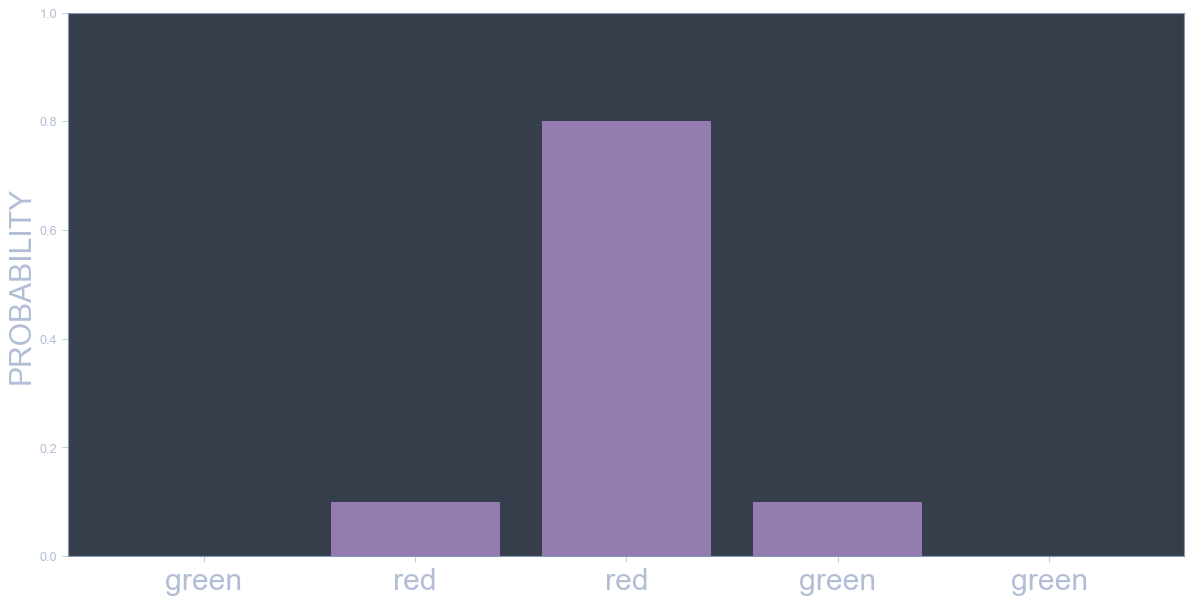

moved one step : 0.000 |  0.100 |  0.800 |  0.100 |  0.000 |  


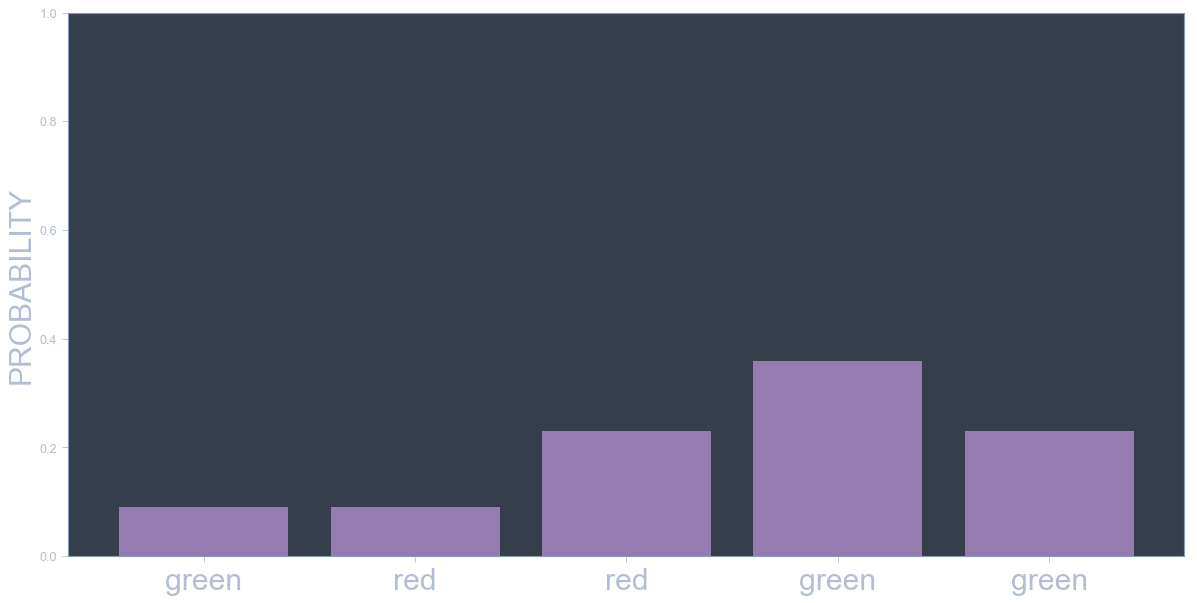

moved 5 one steps: 0.091 |  0.091 |  0.230 |  0.358 |  0.230 |  


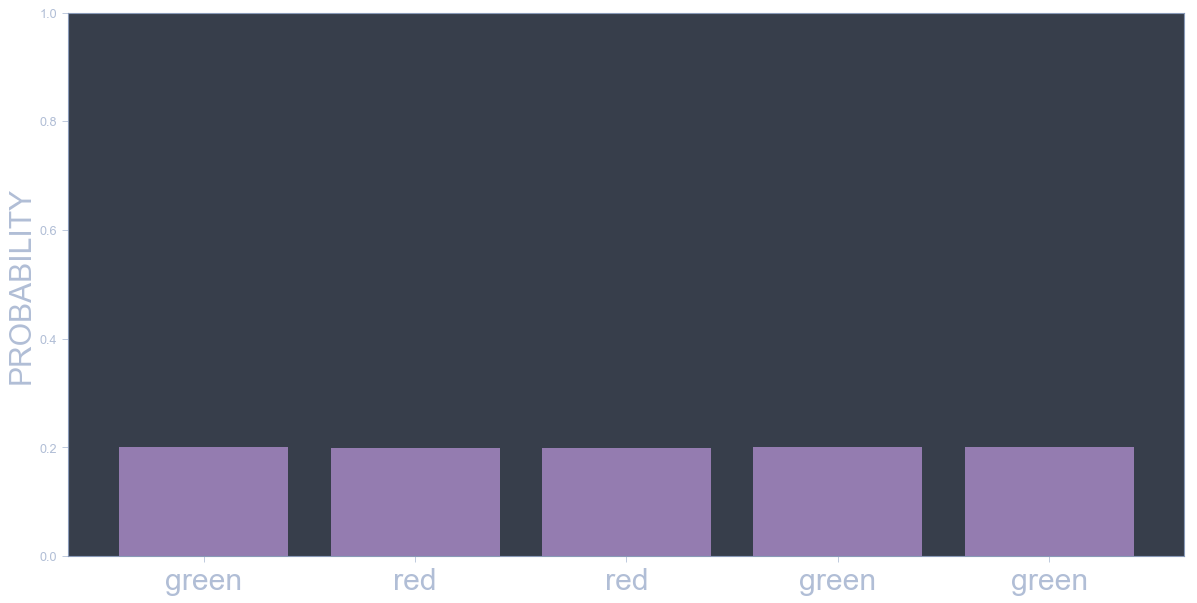

moved 50 step  : 0.200 |  0.200 |  0.200 |  0.200 |  0.200 |  


In [8]:
robot.set_current([0, 1.0, 0, 0, 0])
visualize(robot.current, world, "initial")
visualize(robot.move(1), world, "moved one step")

for i in range(5):
  robot.move(1)

visualize(robot.move(1), world, "moved 5 one steps")

for i in range(50):
  robot.move(1)

visualize(robot.move(1), world, "moved 50 step")

# (EXAMPLE 3)
- Given we don't know where we are
- Then we sensed red
- Then we moved one step
- Then we sensed green
- Then we moved one step

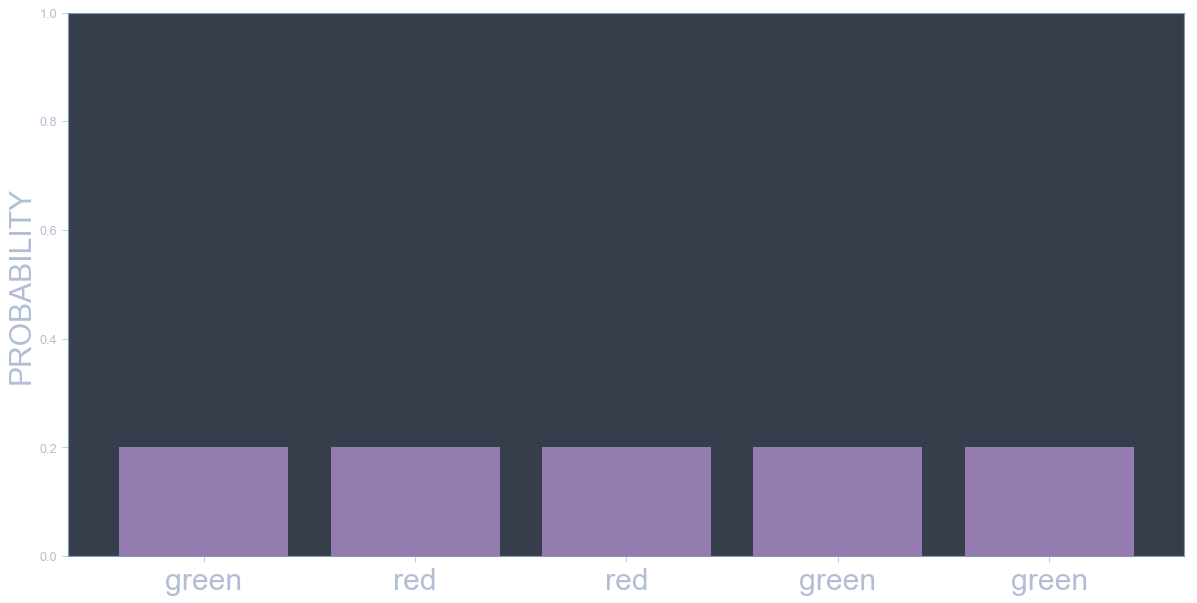

initial        : 0.200 |  0.200 |  0.200 |  0.200 |  0.200 |  


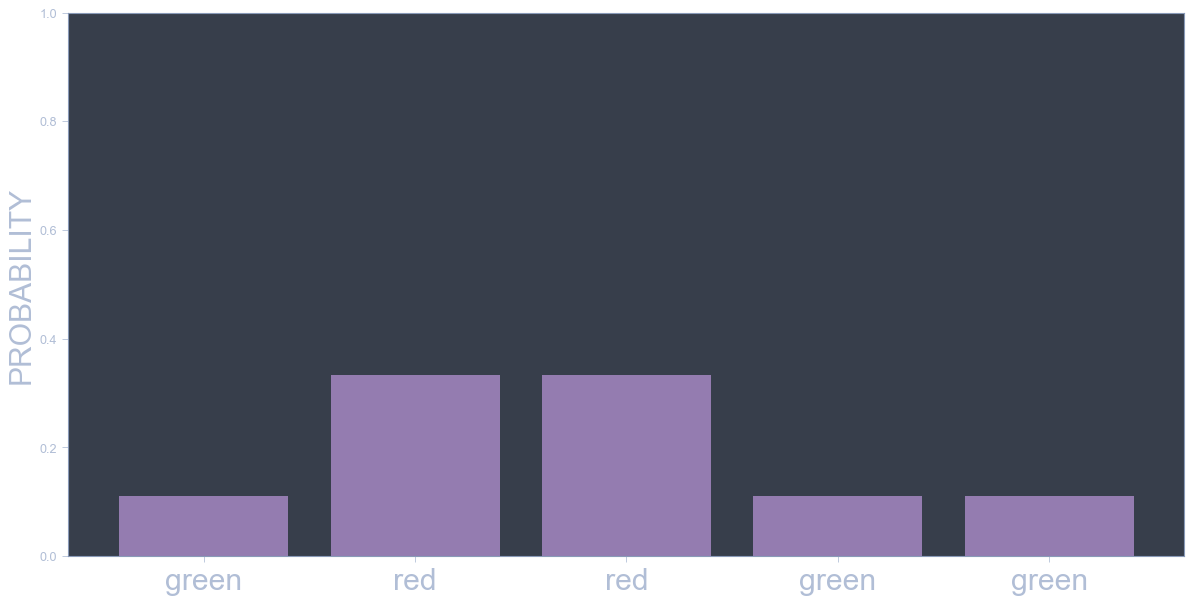

sensed red     : 0.111 |  0.333 |  0.333 |  0.111 |  0.111 |  


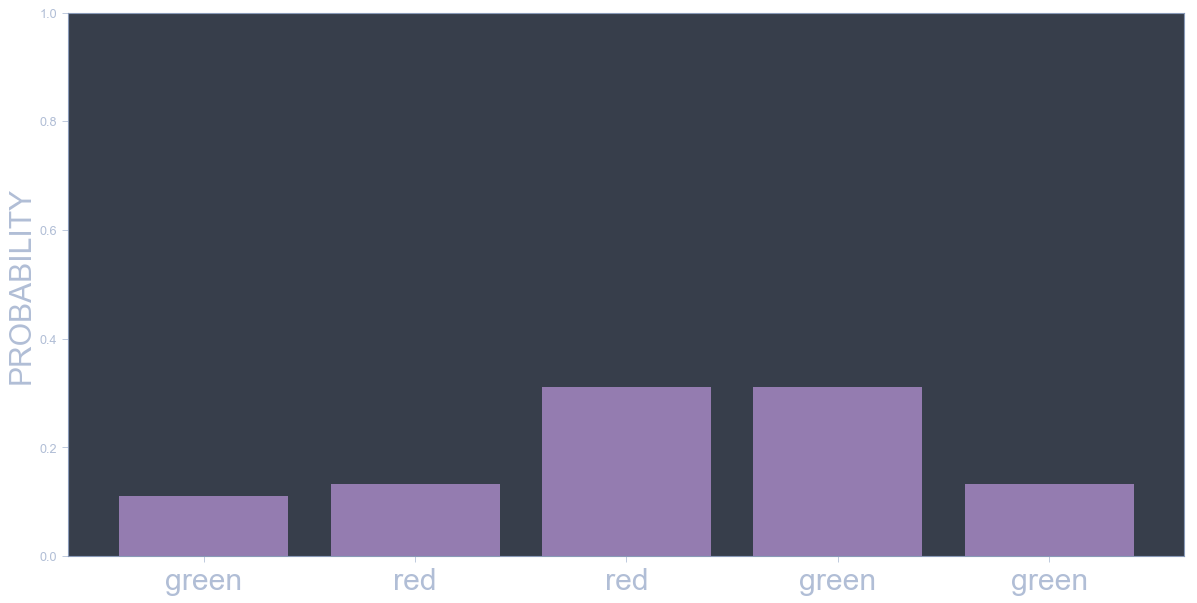

moved 1 step   : 0.111 |  0.133 |  0.311 |  0.311 |  0.133 |  


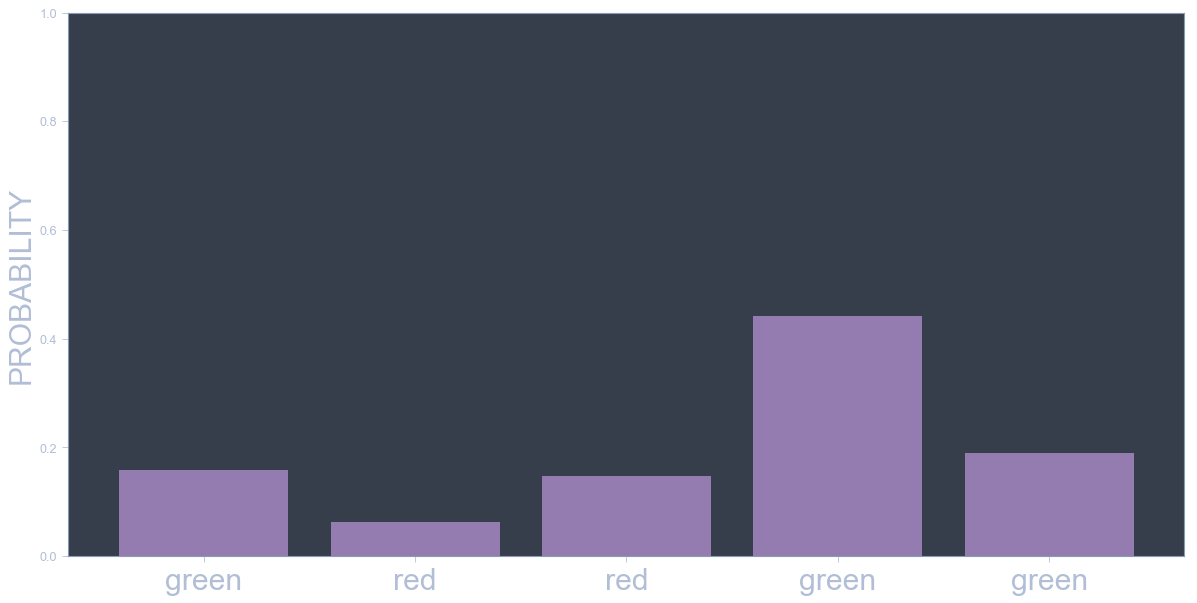

sensed green   : 0.158 |  0.063 |  0.147 |  0.442 |  0.189 |  


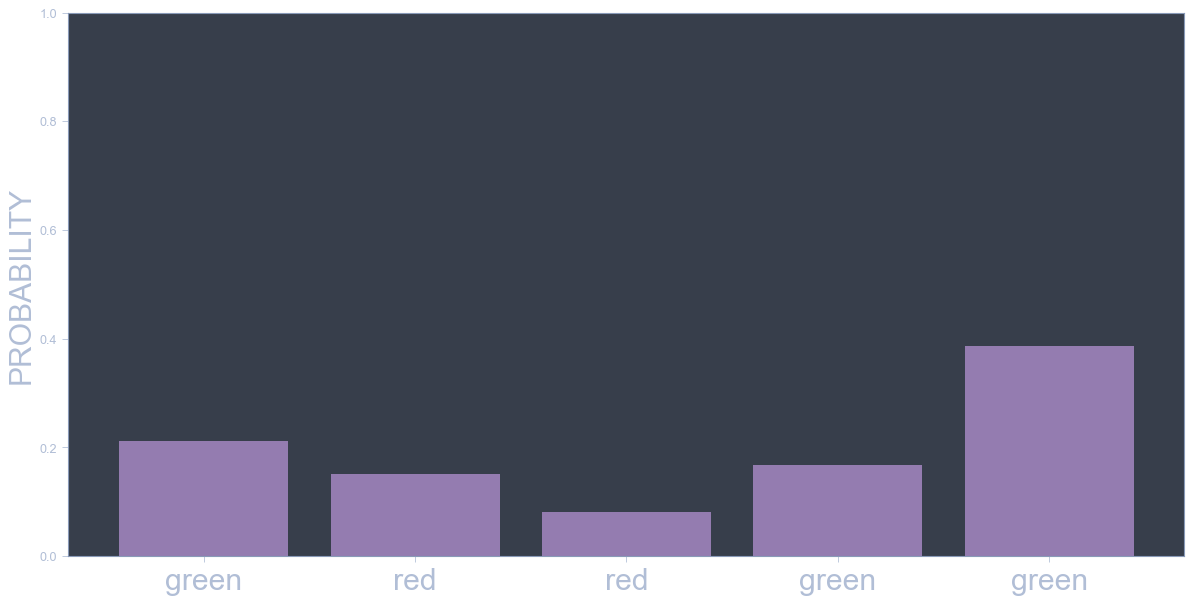

moved 1 step   : 0.212 |  0.152 |  0.081 |  0.168 |  0.387 |  


In [9]:
visualize(robot.confuse(), world, "initial")
visualize(robot.sense('red'), world, "sensed red")
visualize(robot.move(1), world, "moved 1 step")
visualize(robot.sense('green'), world, "sensed green")
visualize(robot.move(1), world, "moved 1 step")


# (EXAMPLE 4)
- Given we don't know where we are
- Then we sensed red 
- Then we moved one step
- Then we sensed red again 
- Then we moved one more step

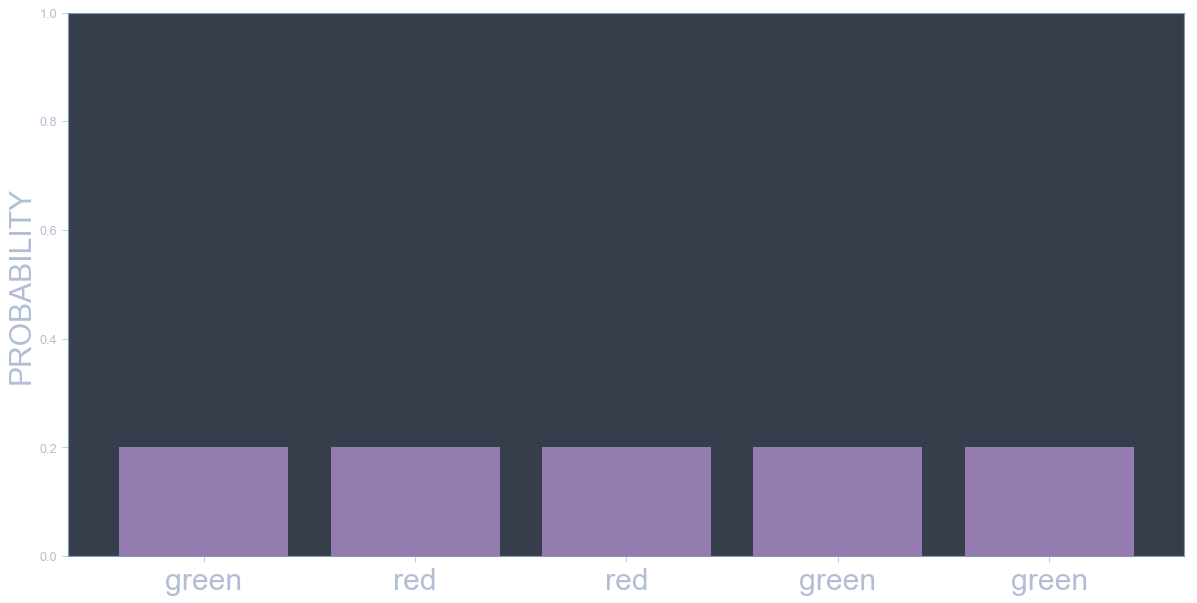

initial        : 0.200 |  0.200 |  0.200 |  0.200 |  0.200 |  


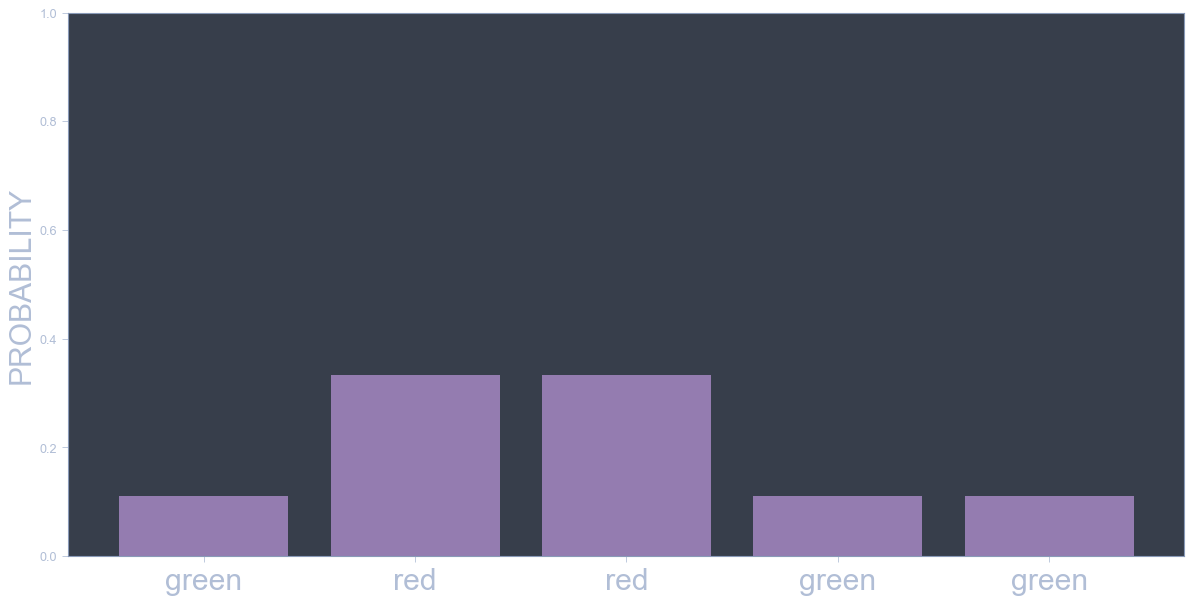

sensed red     : 0.111 |  0.333 |  0.333 |  0.111 |  0.111 |  


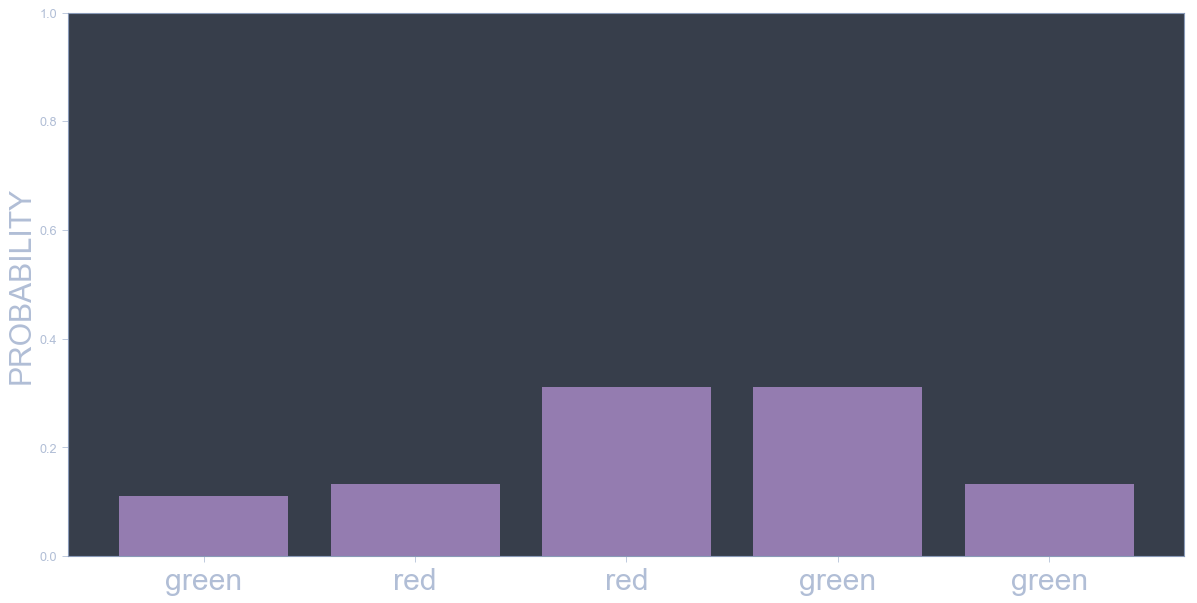

moved 1 step   : 0.111 |  0.133 |  0.311 |  0.311 |  0.133 |  


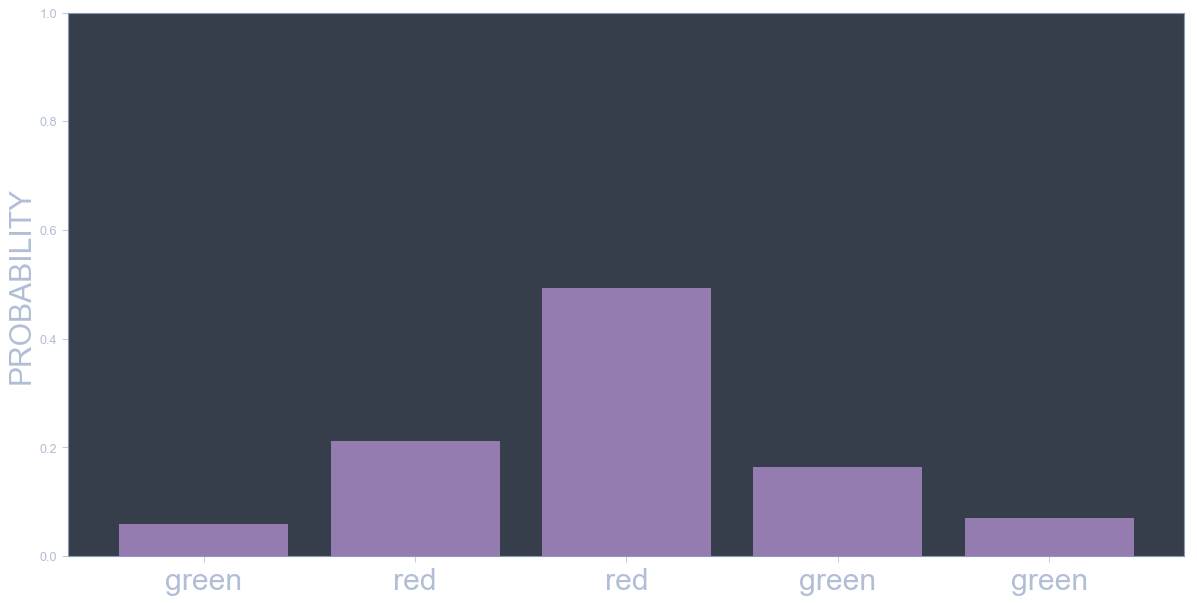

sensed red     : 0.059 |  0.212 |  0.494 |  0.165 |  0.071 |  


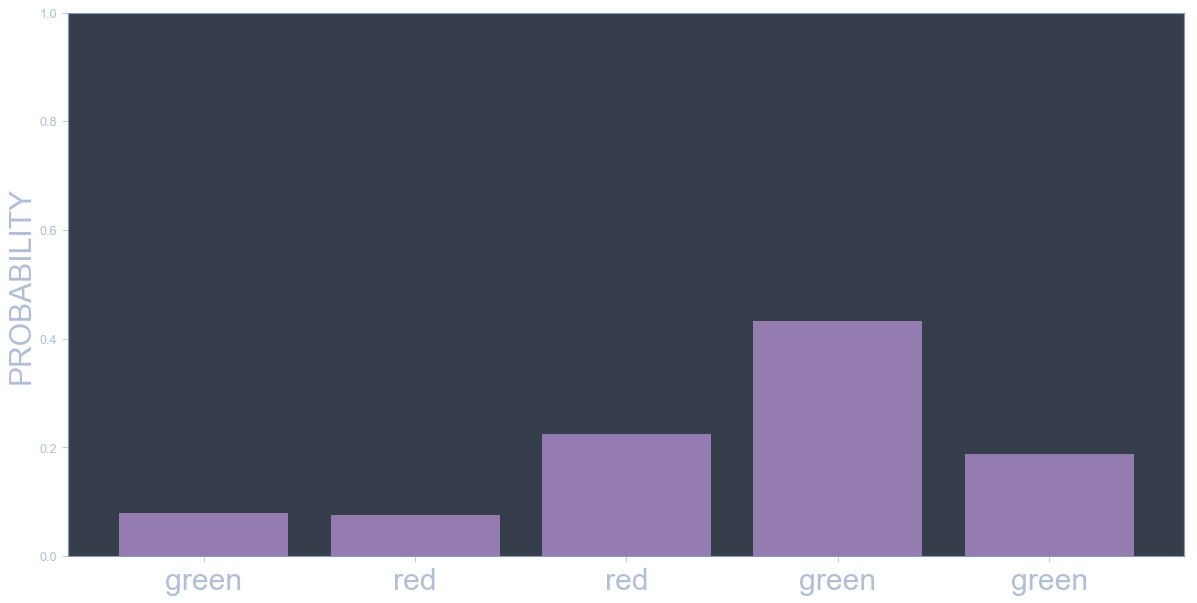

moved 1 step   : 0.079 |  0.075 |  0.225 |  0.433 |  0.188 |  


In [10]:
visualize(robot.confuse(), world, "initial")
visualize(robot.sense('red'), world, "sensed red")
visualize(robot.move(1), world, "moved 1 step")
visualize(robot.sense('red'), world, "sensed red")
visualize(robot.move(1), world, "moved 1 step")


# (OTHER EXAMPLES)
- You can also try out the other scenarios, and check if it makes sense

In [11]:
# 1
robot.set_current([0, 0.5, 0.5, 0, 0])
formatted_print("initial", robot.get_current())
formatted_print("moved one step", robot.move(2))

initial        : 0.000 |  0.500 |  0.500 |  0.000 |  0.000 |  
moved one step : 0.050 |  0.000 |  0.050 |  0.450 |  0.450 |  


In [12]:
robot.set_current([0, 0.5, 0, 0.5, 0])
formatted_print("initial", robot.get_current())
formatted_print("moved one step", robot.move(2))

initial        : 0.000 |  0.500 |  0.000 |  0.500 |  0.000 |  
moved one step : 0.400 |  0.050 |  0.050 |  0.400 |  0.100 |  


In [13]:
robot.set_current([0, 0.25, 0, 0.75, 0])
formatted_print("initial", robot.get_current())
formatted_print("moved one step", robot.move(2))

initial        : 0.000 |  0.250 |  0.000 |  0.750 |  0.000 |  
moved one step : 0.600 |  0.075 |  0.025 |  0.200 |  0.100 |  
